In [359]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

In [360]:
#設定參數
sigma = 0.001
a = 0.001
timestep = 360 #期數
length = 30  #years
forward_rate = 0.01
r = 0.05  # risk free rate
vol = 0.01
day_count = ql.Thirty360()
todays_date = ql.Date(12, 5, 2020)
num_paths = 300 #路徑數
S0 = 100 #股票現價
K = 100 #履約價
dt = length/timestep #單位時間 = 年數/期數


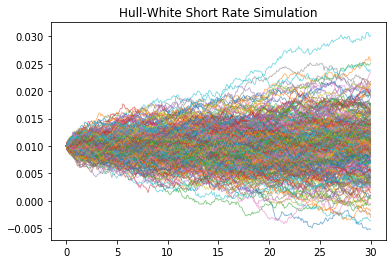

In [361]:
#HW model，參考自pdf中的連結： http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html

ql.Settings.instance().evaluationDate = todays_date
spot_curve = ql.FlatForward(todays_date, 
ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(
           ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

#得到時間間隔(time)與各個路徑的short rate(arr)
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    
    return np.array(time), arr

#輸出short rate simulation

time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

In [362]:
#蒙地卡羅法，參考自pdf中的連結：https://allanhsu83117.github.io/2017/11/monte-carlo-and-options-pricing/

# 建立儲存每期ST的array
ST = np.zeros((num_paths,timestep+1))
# 設定初始價格
#[:,x]是np的特殊寫法，指的是每一行中的x位數，下面是設定所有ST的起始皆為S0
ST[:,0] = np.log(S0)



#r為hw model模擬的結果
#path[:,n+1]為每一期的結果
for n in range(timestep):
    e = np.random.standard_normal(num_paths)
    ST[:,n+1] = ST[:,n] + (paths[:,n+1]-0.5*vol**2)*dt + vol*(dt**0.5)*e

# 取出末期價格
ST_N = np.exp(ST[:, -1])





In [363]:
#參考的連結與上面一個cell相同

#蒙地卡羅法的買權賣權價格
#折現到現在
C = np.mean(np.exp(-r*length)*np.maximum(ST_N-K,0))
P = np.mean(np.exp(-r*length)*np.maximum(K-ST_N,0))

print("call price is",C)
print("put price is", P)

call price is 7.893165777229117
put price is 0.0010083628711486665
